In [1]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import glob

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score

import cv2

import seaborn as sns

<h4>Read the Images</h4>

In [2]:
tumor = []
path_yes = './brain_tumor_dataset/yes/*.jpg'

#read the files using iglob, translate images using cv2
for f in glob.iglob(path_yes):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    
    #turn image back into rgb
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    
    tumor.append(img)

In [3]:
healthy = []
path_no = './brain_tumor_dataset/no/*.jpg'

#read the files using iglob, translate images using cv2
for f in glob.iglob(path_no):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    
    #turn image back into rgb
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    
    healthy.append(img)

In [4]:
healthy = np.array(healthy)
tumor = np.array(tumor)
both = np.concatenate((healthy, tumor))

<h4>Visualize the MRI Images</h4>

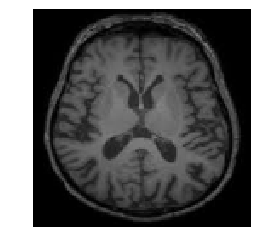

In [5]:
fig, ax = plt.subplots()

ax.imshow(healthy[0])

ax.axis('off')
plt.show()

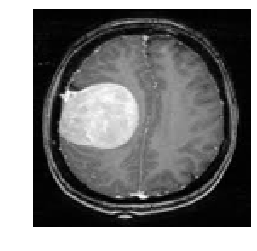

In [6]:
fig, ax = plt.subplots()

ax.imshow(tumor[0])

ax.axis('off')
plt.show()

In [7]:
def viz_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    fig, axs = plt.subplots(1, num, figsize = (16,9))
    for i in range(num):
        axs[i].imshow(healthy_imgs[i])
        axs[i].axis('off')
        axs[i].set_title('Healthy')
    plt.show()
        
    fig, axs = plt.subplots(1, num, figsize = (16,9))
    for i in range(num):
        axs[i].imshow(tumor_imgs[i])
        axs[i].axis('off')
        axs[i].set_title('Tumor')
        
    plt.show()
        

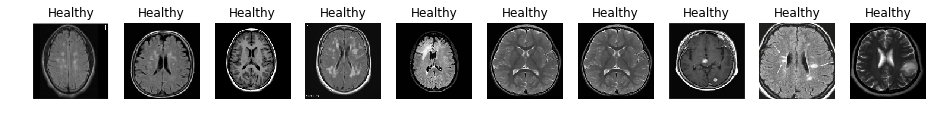

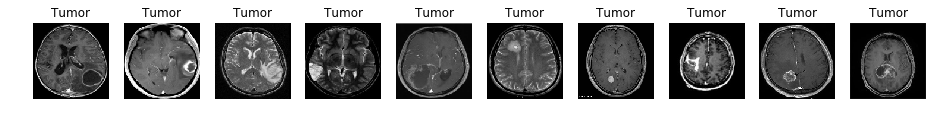

In [8]:
viz_random(healthy, tumor, 10)

<h4>Create Torch Dataset Class</h4>

In [9]:
class Dataset(object):
    def __getitem__(self,index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __add__(self,other):
        return ConcatDataset([self,other])

<h4>MRI Custom Dataset Class</h4>

In [10]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        path_yes = './brain_tumor_dataset/yes/*.jpg'
        path_no = './brain_tumor_dataset/no/*.jpg'

        #read the files using iglob, translate images using cv2
        for f in glob.iglob(path_yes):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))

            #turn image back into rgb
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))

            tumor.append(img)
            
        #read the files using iglob, translate images using cv2
        for f in glob.iglob(path_no):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))

            #turn image back into rgb
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))

            healthy.append(img)
        
        #put the images in an array
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)
        
        #labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        #set the images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label), axis=0)
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self,index):
        sample = {'image': self.images[index], 'label':self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255

In [11]:
mri = MRI()
mri.normalize()

<h4>Use a Dataloader</h4>

In [12]:
dataloader = DataLoader(mri, batch_size=10, shuffle=True)

In [13]:
for sample in dataloader:
    img = sample['image']
    print(img.shape)
#     img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
#     plt.imshow(img)
#     plt.show()

torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])
torch.Size([5, 3, 128, 128])


<h4>The Model</h4>
<p>We are using a convolutional neural network to work with grid-like data.</p>
<p>This creates layers that compresses and stretches data.</p>

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84,out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        return x

<h4>How dumb is a new Neural Network?</h4>

In [15]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Select gpu if available, otherwise use cpu to process
model = CNN().to(device)

In [16]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [17]:
model.eval()

outputs = []
y_true = []

with torch.no_grad():
    for d in dataloader:
        image = d['image'].to(device)
        label = d['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

C:\Users\bpohl\anaconda3\envs\MRI\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [19]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    x[x>=threshold] = maximum
    x[x<threshold] = minimum
    return x

In [20]:
accuracy_score(y_true, threshold(outputs))

0.6285714285714286

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

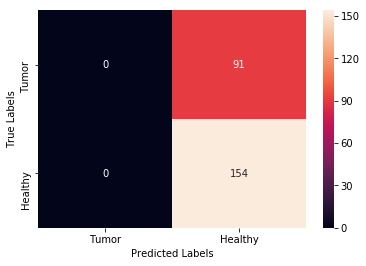

In [21]:
cm = confusion_matrix(y_true, threshold(outputs))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Tumor', 'Healthy'])
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'])

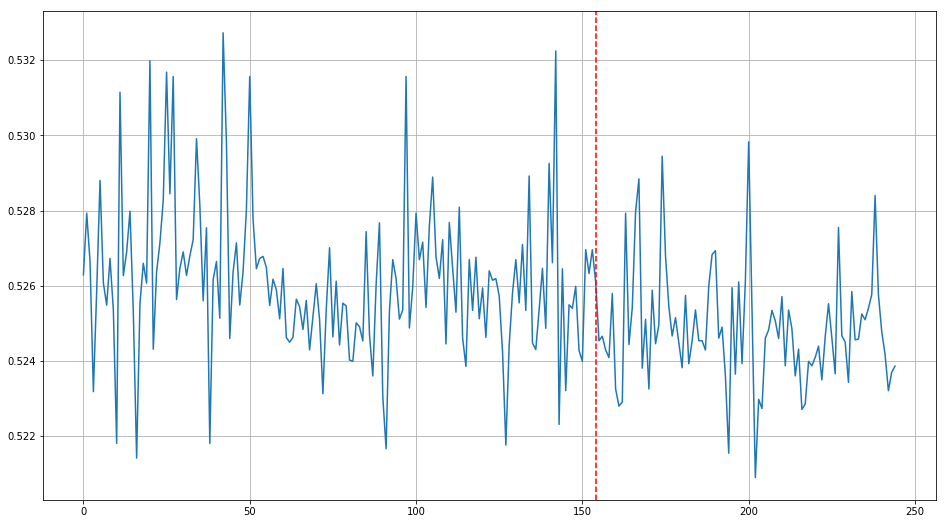

In [22]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

#an untrained model is just noise. Right = healthy, left = tumor

<h4>Train the model</h4>

In [23]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta) #if you don't know what optimizer to use, try this one first
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [24]:
for epoch in range(1, EPOCH):
    losses = []
    for d in dataloader:
        optimizer.zero_grad() #reset optimizer
        data = d['image'].to(device)
        label = d['label'].to(device)
        y_hat = model(data)
        #define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if (epoch+1) % 10 == 0:
        print(f'Train Epoch: {epoch+1}\tLoss:{np.mean(losses):.6f}')
        
    

Train Epoch: 10	Loss:0.623376
Train Epoch: 20	Loss:0.586207
Train Epoch: 30	Loss:0.530414
Train Epoch: 40	Loss:0.510588
Train Epoch: 50	Loss:0.492121
Train Epoch: 60	Loss:0.460072
Train Epoch: 70	Loss:0.442848
Train Epoch: 80	Loss:0.426212
Train Epoch: 90	Loss:0.409470
Train Epoch: 100	Loss:0.389564
Train Epoch: 110	Loss:0.383659
Train Epoch: 120	Loss:0.350827
Train Epoch: 130	Loss:0.321128
Train Epoch: 140	Loss:0.304478
Train Epoch: 150	Loss:0.282879
Train Epoch: 160	Loss:0.253874
Train Epoch: 170	Loss:0.246405
Train Epoch: 180	Loss:0.217925
Train Epoch: 190	Loss:0.180901
Train Epoch: 200	Loss:0.167161
Train Epoch: 210	Loss:0.140010
Train Epoch: 220	Loss:0.118652
Train Epoch: 230	Loss:0.106655
Train Epoch: 240	Loss:0.094098
Train Epoch: 250	Loss:0.071810
Train Epoch: 260	Loss:0.058992
Train Epoch: 270	Loss:0.052087
Train Epoch: 280	Loss:0.041335
Train Epoch: 290	Loss:0.033384
Train Epoch: 300	Loss:0.030028
Train Epoch: 310	Loss:0.027645
Train Epoch: 320	Loss:0.021030
Train Epoch: 330	

In [25]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    for d in dataloader:
        image = d['image'].to(device)
        label = d['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

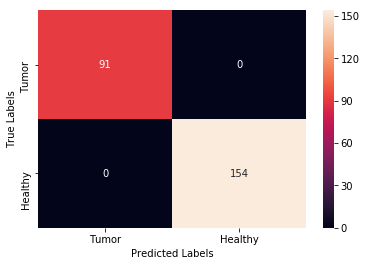

In [26]:
cm = confusion_matrix(y_true, threshold(outputs))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Tumor', 'Healthy'])
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'])

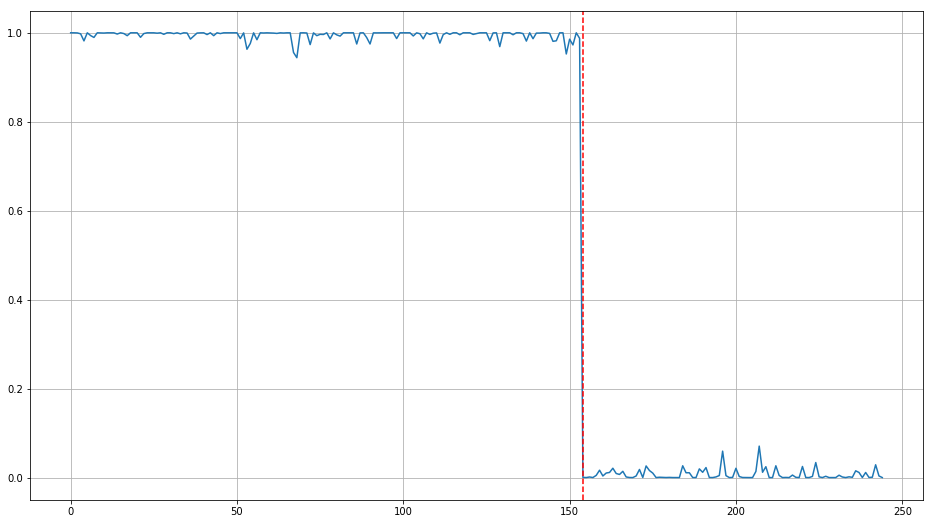

In [27]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


This is what it looks like when you train a model and test a model with the exact same data